# Getting started with the Event Based Model
## Author: Neil Oxtoby, UCL (conversion to RISE by David Cash)



## Objectives:

At the end of this notebook, you will be have learned how to fit an event-based model of disease progression based on simulated data. After going through this notebook, you should have the knowledge to set up the EBM for your data in the project notebook.

* For more information, please see the [Disease Progression Modelling website](https://disease-progression-modelling.github.io)
* Code and notebooks taken from the [KDE-EBM Github repository](https://github.com/ucl-pond/kde_ebm)


## Setup 
The steps for performing an EBM analysis typically involve:
- Load input data: usually in some tabular format (i.e. a spreadsheet)
- Identify which features to use
- Determine probability distributions for abnormality in each feature
- Fit the event-based model
- Perform cross-validation


In [1]:
# First import some packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18}) # default fontsize

## Simulated data - Patients
* 100 patients, where we know their "actual" time from onset. 
  * Patients are evenly spaced out from 0 (onset of AD) to 20 years after onset 
* Four features: 0 represents normal, 1 abnormal
  * Patients follow a sigmoidal transition from normal to abnormal
* Matrix of features will be stored in two-dimensional matrix `X_patients` .

In [2]:
#Define some key parameters for our simulated data
num_features = 4   # number of events/features
num_patients = 100 # number of patients
disease_duration = 20 # Number of years 
noise_scale = 0.1 # Amount of noise in the biomarkers

In [4]:
# Get the colors of the plot so points and lines can be the same. 
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# List of dictionaries for key plotting information of each biomarker
# Notice the onset changes, Biomarker 1 starts at year 4, biomarker 2 @ year 8, etc)
feature_info = [
    { 'label': 'Biomarker 1', 'id': 0, 'gradient': 1, 'onset': 4, 'color': colors[0]},
    { 'label': 'Biomarker 2', 'id': 1, 'gradient': 1, 'onset': 8, 'color': colors[1]},
    { 'label': 'Biomarker 3', 'id': 2, 'gradient': 1, 'onset': 12, 'color': colors[2]},
    { 'label': 'Biomarker 4', 'id': 3, 'gradient': 1, 'onset': 16, 'color': colors[3]}
]

## The lambda command in Python
* The `lambda` keyword is a way to define a quick function in-line that you want to re-use later in the program.
* Here we are going to use it to create sigmoidal functions to simulate the trajectory of each biomarker

In [5]:
# Sigmoid function: t, a, b - are the parameters that are passed as inputs
# a and b have default values
sigmoid = lambda t, a=1, b=-10 : 1/(1 + np.exp(-a*(t-b)))

In [6]:
# np.linspace makes a vector with evenly spaced increments from start (0)
# to end (disease_duration=20) with the total number of increments specified as the number of patients (100)
disease_time = np.linspace(0, disease_duration, num_patients)

# Creates the two dimensional matrix holding the features of each patient
X_patients = np.empty(shape=(num_patients,num_features))

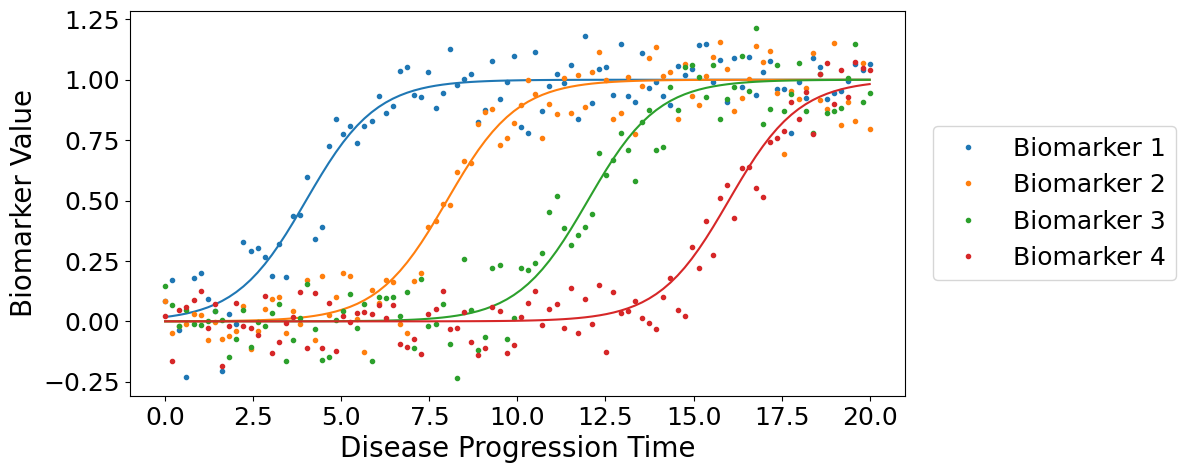

In [7]:
#Create a figure
fig,ax = plt.subplots(figsize=(10,5))    
# Loop through each feature, plotting the feature along the way
for feature in feature_info:
    id = feature['id']
    x = sigmoid(t=disease_time,a=feature['gradient'],b=feature['onset'])  # ideal value of sigmoid
    ax.plot(disease_time, x, c=feature['color'])
    X_patients[:,id] = x + np.random.normal(0, noise_scale, num_patients) # sigmoid plus noise
    ax.plot(disease_time, X_patients[:,id],'.',label=feature['label'])
 
ax.set_xlabel("Disease Progression Time",fontsize=20) 
ax.set_ylabel("Biomarker Value",fontsize=20)
ax.legend(bbox_to_anchor=(1.02, 0.5),loc="center left")

## Simulated data - Controls
* The same four features measured as patients
* For simplicity, the same number of controls (100) as patients
* None of the controls will have abnormal values, just some random noise around zero. 
* We will store this matrix of observations in `X_controls`

In [8]:
#* Sample some controls
X_controls = np.empty(shape=X_patients.shape)
for k in range(num_features):
    X_controls[:,k] = np.random.normal(0, noise_scale, num_patients)

## Review the simulated data

### Visual inspection of feature distributions

* Does the feature relate to the disease process? No use including it if not abnormal
* Let's first *look at the data* by visually checking the feature's distribution in our patient group and control group  

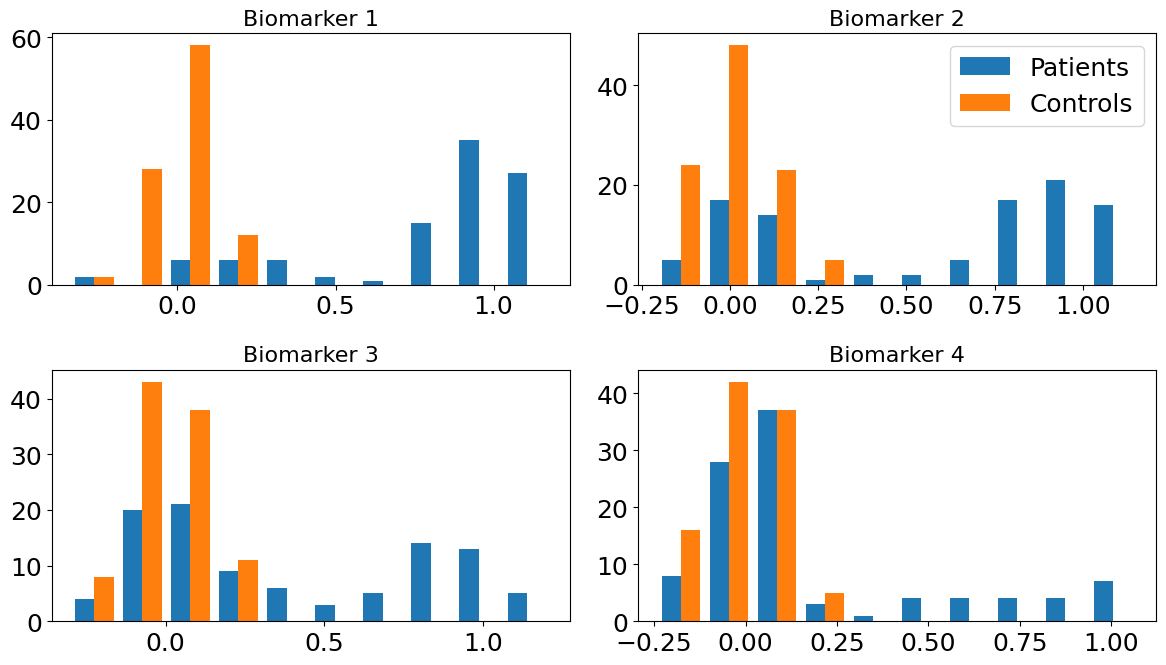

In [9]:
#* Plot histogram for each feature
nrows = int(num_features/2)
ncols = 2
fig,ax = plt.subplots(nrows, ncols,figsize=(12,7))
for k in range(num_features):
    plt_row = int(np.floor(k/2))
    plt_col = k % 2
    ax[plt_row, plt_col].hist([ X_patients[:,k],X_controls[:,k]],label=['Patients','Controls'])
    ax[plt_row, plt_col].set_title('Biomarker %i' % (k+1),fontsize=16)
ax[0,1].legend()
fig.tight_layout()

### Basic statistical tests
* Null hypothesis: there are no "differences" between groups.
* Non-parametric Mann-Whitney U test to assess a feature's ability to discriminate between patients and controls
  * No assumption about the underlying distribution
* P-value: the probability that the null hypothesis is true given the data
* Effect size: (difference in medians between groups) / ("width" of controls distribution)

In [9]:
from scipy import stats
print('Mann Whitney U test')
# Loop through features
for k in range(num_features):
    x_c = X_controls[:,k]
    x_p = X_patients[:,k]
    effect_size = np.absolute(np.median(x_p)-np.median(x_c))/stats.median_abs_deviation(x_c)
    u,p = stats.mannwhitneyu(x_c,x_p)
    print('Biomarker %i\n - effect size = %.3g\n - u = %i, p = %.2g' % (k+1,effect_size,u,p))

Mann Whitney U test
Biomarker 1
 - effect size = 12.3
 - u = 327, p = 1.7e-30
Biomarker 2
 - effect size = 11.2
 - u = 1387, p = 5.4e-19
Biomarker 3
 - effect size = 2.38
 - u = 2345, p = 4.4e-11
Biomarker 4
 - effect size = 1.08
 - u = 3140, p = 2.8e-06


* All four statistical tests show substantial evidence of a difference between patients and controls
  * So they can all be included in the EBM!
* Biomarkers that have earlier onset show the most abnormal values and thus the largest effect sizes (and lowest p-values)

## Prepare data for analysis with EBM
* Let's organise the data in a structure that is ready for use in the EBM package. 
* Combine patient feature matrix `X_patients` with matrix for controls `X_controls` into `X_combined`
* We also need to assign *labels* to tell the EBM who are patients and who are controls
  * Stored in `y_patients` and `y_controls` and then combined into `Y_combined` 
* This combination is achieved by vertically stacking one matrix on top of the other using numpy's `concatenate` function.

In [10]:
#* Setup data for fitting
y_patients = np.ones(shape=(X_patients.shape[0],1))
y_controls = np.zeros(shape=(X_controls.shape[0],1))

X_combined = np.concatenate((X_patients,X_controls),axis=0)
Y_combined = np.concatenate((y_patients,y_controls),axis=0)
# Make sure that these labels are stored as integer format.
Y_combined = Y_combined.flatten().astype(int)

## Defining abnormality in each biomarker
* Despite the statistical evidence of group separation...
  * Some "controls" might have abnormal biomarkers despite appearing normal
  * Some patients may have normal values in biomarkers, as they have not yet turned abnormal
* What we want to do is to identify normal and abnormal distributions from all of the data
  * If we do that, then we can compute the probability that an "event" has occurred, $p(data|event)$
  * The EBM is a probabilistic framework - there is no magic cutpoint that dichotomises individuals into normal and abnormal
  * Thus the EBM can have patients progress to different stages based on cumulative abnormality.


In [11]:
# Import the needed functions from the EBM toolbox
from kde_ebm.mixture_model import fit_all_kde_models
from kde_ebm.plotting import mixture_model_grid, mcmc_uncert_mat, mcmc_trace, stage_histogram
from kde_ebm.mcmc import mcmc, parallel_bootstrap, bootstrap_ebm, bootstrap_ebm_fixedMM, bootstrap_ebm_return_mixtures


Rather than calling these biomarker 1,2,3,4 we will use some more sensible labels based on when they occur. We also need to tell the EBM the trajectory of abnormality for each biomarker, as some measures are abnormal if they go up and others are abnormal if they go down.

In [12]:
# Label the biomarkers/events
event_labels = ['Early','Early-ish','Late-ish','Late']
# The EBM needs to know which direction is abnormal 
# (1 abnormal means increase, -1 abnorma means decrrease)
event_disease_direction_dict = {'Early':1,'Early-ish':1,'Late-ish':1,'Late':1}
event_disease_direction = [event_disease_direction_dict[f] for f in event_labels]

## Mixture models
* To identify the probability $p(event|data)$, we will fit each biomarker distribution using mixture models.
* Mixture models are a widely-used machine learning method to identify sub-populations from the overall population
* The most common approach is a Gaussian mixture model, which assumes each subpopulation can be described by a Gaussian
* Here, we will use a non-parametric approach called a Kernel Density Estimator (KDE), which does not make any assumptions of the underlying distributions

## Example of a Gaussian Mixture Model
![Mixture model](./SUVR_Fit_Hist.png)

In [13]:
kde_mixtures = fit_all_kde_models(
    X_combined, Y_combined,
    implement_fixed_controls = True,
    patholog_dirn_array      = event_disease_direction
)

## Visualize mixture model fits
* Despite each biomarker occurring at different times, `p(data|event)` looks roughly the same
  * Biomarkers become abnormal at roughly the same levels (0.25 to 0.50), since the range of normal measurements is essentially the same for all four biomarkers
* While the biomarkers are all classified as abnormal at the same levels, the number of patients who have a value classified as abnormal is different for each biomarker. 

(<Figure size 1200x1200 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'Early'}>,
         <AxesSubplot:title={'center':'Early-ish'}>],
        [<AxesSubplot:title={'center':'Late-ish'}>,
         <AxesSubplot:title={'center':'Late'}>]], dtype=object))

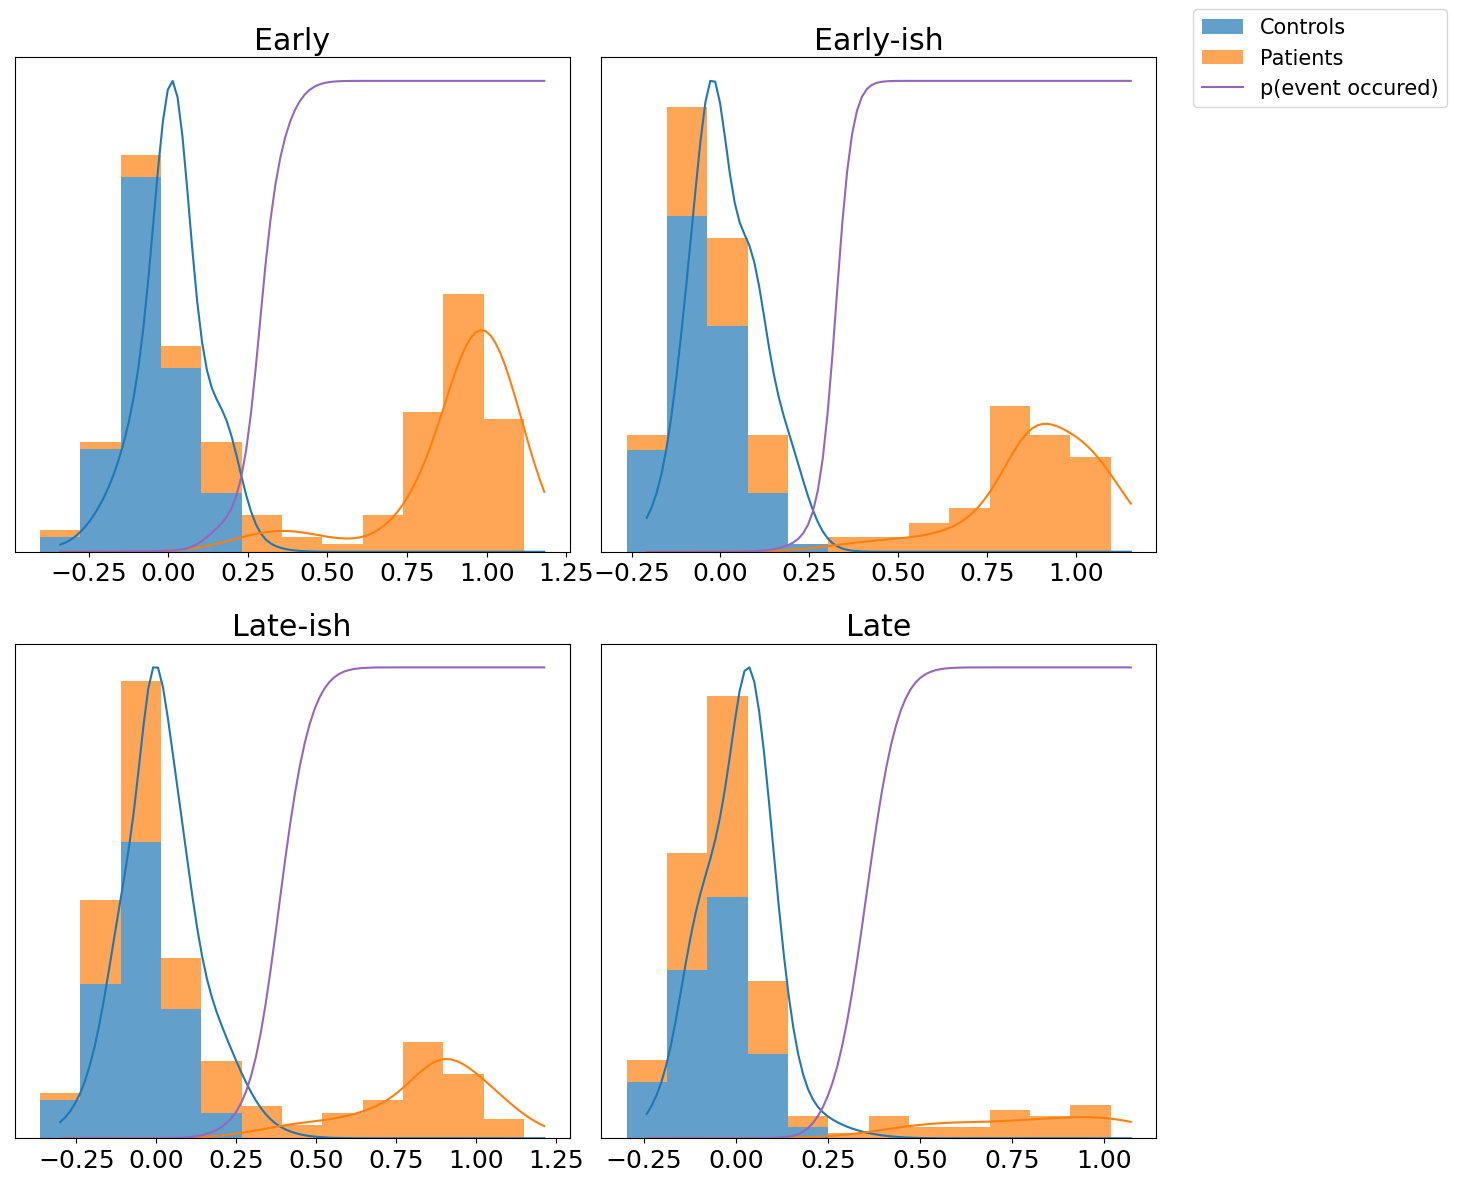

In [14]:
#* View the mixture models
mixture_model_grid(
    X_combined,Y_combined,
    kde_mixtures,
    score_names=event_labels,
    class_names=['Controls','Patients']
)

## Uncertainty in the ordering
* The model will return the posterior, which is a point estimate of the most probable ordering of events, given the data. 
* Ideally, we would get the posterior from the ordering with the maximum likelihood
* But how can we be sure which ordering has the maximum likelihood if there are many features included in the EBM
  * For $N$ features, there are $N!$ possible orderings. 
  * So our case of four orderings is manageable: there are $4!$ or 24 possible orderings. 
  * However if we doubled the number of features to eight, that would be $8!$ or 40,320 possible orderings.

## MCMC sampling
* The solution to this problem is to use Markov Chain Monte Carlo (MCMC) method. It is a standard approach to  approximate a model posterior when you can't do an exhaustive search.
* MCMC generates _random samples from the posterior_ (the full set of possible sequences), and keeps only those sequences that increase the likelihood (ideally towards the maximum).
  * In practice, we could get stuck in a local maxima, so we use multiple random initialisations
* More information about the MCMC algorithm used in EBM can be found in [Fonteijn _et al._, NeuroImage (2012)](https://doi.org/10.1016/j.neuroimage.2012.01.062).

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 7615.62it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 7733.39it/s]


ML order   : Early, Early-ish, Late-ish, Late


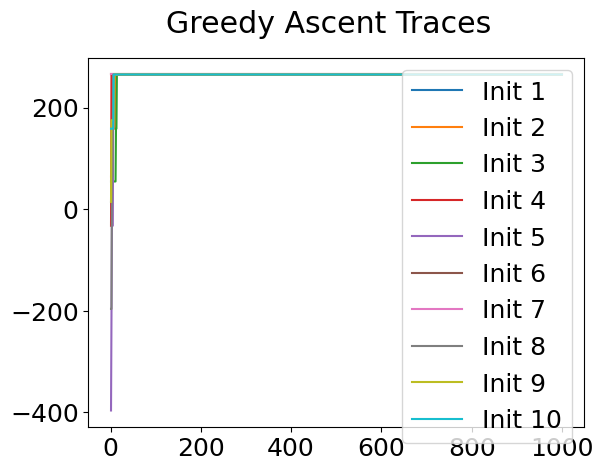

In [15]:
#* Perform MCMC sequencing and store results in mcmc_samples
mcmc_samples = mcmc(X_combined, kde_mixtures)
#* Obtaine the maximum Likelihood sequence over all samples
seq_ml = mcmc_samples[0].ordering
# print('ML sequence: {0}'.format(seq_ml))
print('ML order   : %s' % ', '.join([event_labels[k] for k in seq_ml]))
      

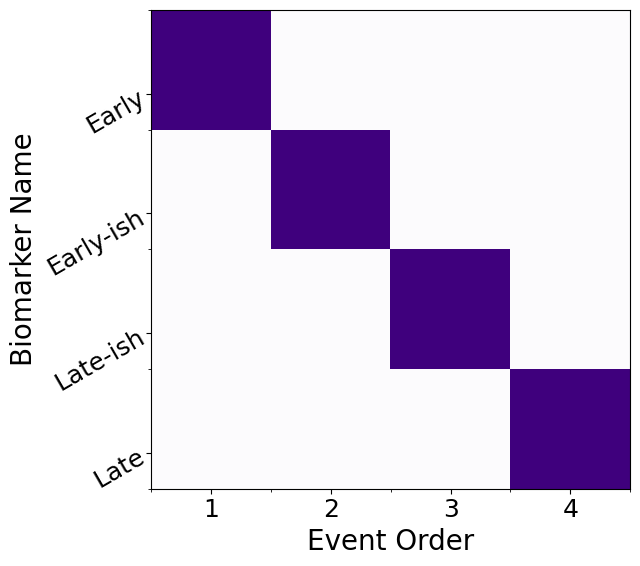

In [16]:
# View the ML posterior
f,a = mcmc_uncert_mat(mcmc_samples, ml_order=None, score_names=event_labels)

* The ordering is as we would expect it to be, the Early one is first, followed by Early-ish, Late-ish, and Late. 
* This corresponds with how these biomarkers were set to transition from normal to abnormal at 4, 8, 12, and 16 years, respectively. 


In [17]:
# We are going to use the results from the MCMC sampling later, so we are going to save them in a dictionary.
ebm_results = {"mixtures": kde_mixtures, "mcmc_samples": mcmc_samples, "sequence_ml": seq_ml}

## Positional Variance Diagrams — estimating order uncertainty

* The _positional variance diagram_, or PVD, indicates the uncertainty of the resulting orderings.
* Uncertainty of these orderings could be due to heterogeneity in the population or noise in the measurements.
* The darkness of the box indicates more certainty in the position, fainter boxes indicate less


In [18]:
# Import some helper functions from a local file.
import kde_utils 
# Get the PVD, the outputs are
# a two-dimensional matrix representing the positional variance diagram
# and the sequence of the most likely events
pvd_ml, seq_ml = kde_utils.extract_pvd(ml_order=seq_ml,samples=mcmc_samples)
# Sort the PVD so that the earliest marker is at the top and latest at the bottom
reorder_ml = np.argsort(seq_ml)
pvd_ml_ = pvd_ml[:][reorder_ml]


In [19]:
#Helper variables to make PVD plot nicer
labels = event_labels
tick_marks_x = np.arange(0,4,1)
x_labs = range(1, 5,1)
tick_marks_y = np.arange(4)


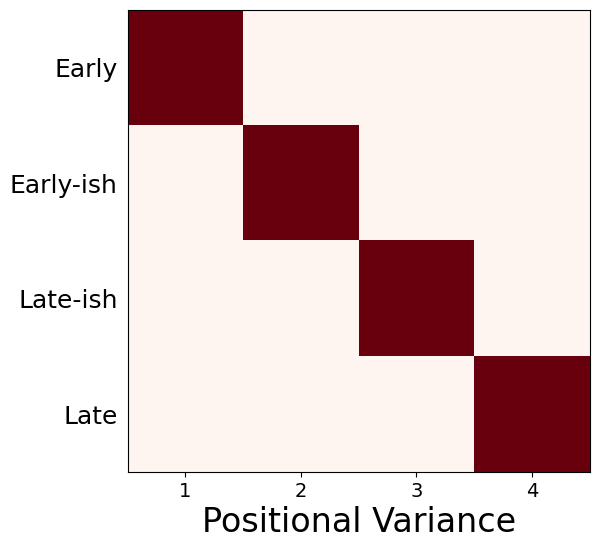

In [20]:
fig, ax = plt.subplots(1,1,figsize=(9, 6),sharey=False)
ax.imshow(pvd_ml_[:][seq_ml], interpolation='nearest', cmap='Reds') #Plot the PVD
ax.set_xticks(tick_marks_x)
ax.set_xticklabels(x_labs, rotation=0,fontsize=14) # Make the x labels nicer 
ax.set_yticks(tick_marks_y+0.0)
ax.tick_params(axis='y',color='w')
ax.set_yticklabels(labels, rotation=0,rotation_mode='anchor',fontsize=18) # Use biomarker names for y tick labels
ax.set_xlabel('Positional Variance', fontsize=24)
ax.grid(False)

## Patient staging utility
* We can use the ordering generated from the EBM to identify at which point, or stage, each individual is within the disease process. 
* For more details on staging (see [Young et al, Brain 2014](https://doi.org/10.1093/brain/awu176)) 
  * Compares biomarkers from each individual  with the model and calculates a `p(event)` vector. 
  * From this vector, it determines the most likely stage 
  * We can use this on follow-up timepoints, or from individuals that aren't included in generating the EBM


In [21]:
#* Staging
#* Maximum-likelihood model stage: could include longitudinal data, including followups not used to train the EBM
prob_mat_ml, stages_long_ml, stage_likelihoods_long_ml, stages_long_ml_expected = kde_utils.ebm_staging(
    x=X_combined,
    mixtures=kde_mixtures,
    samples=mcmc_samples
)
stages_long = stages_long_ml

Now that we have obtained stages for each individual, we will plot a histogram of the stages assigned to each individual (both controls and patients). 

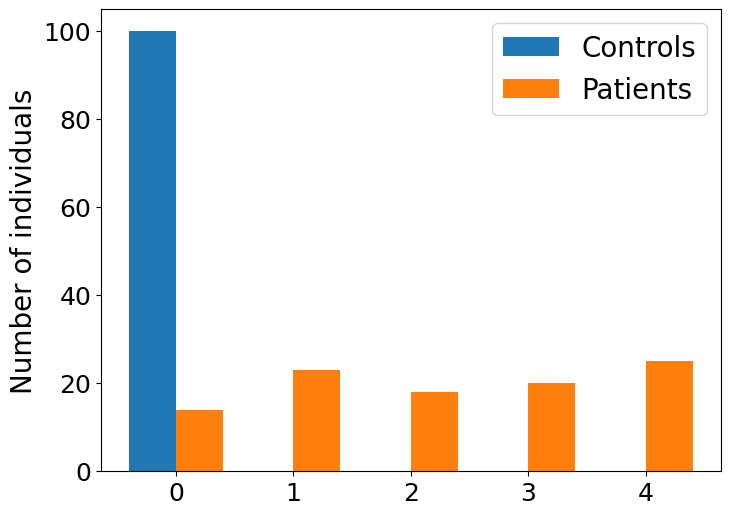

In [22]:
fig, ax = plt.subplots(figsize=(8,6))

ax.hist([ stages_long[Y_combined==0], stages_long[Y_combined==1]],bins=np.arange(-0.5,num_features+1.5,1))
ax.set_ylabel('Number of individuals',fontsize=20)
ax.legend(['Controls','Patients'],fontsize=20)

* All of the controls are in stage 0 --> no evidence of disease
* The patients are slit evenly across each of the potential disease stages

* We will again plot the features of each individual with respect to disease time. 
* **This time** we will colour each individual's points according to their disease stage. 

Text(0, 0.5, 'Biomarker Value')

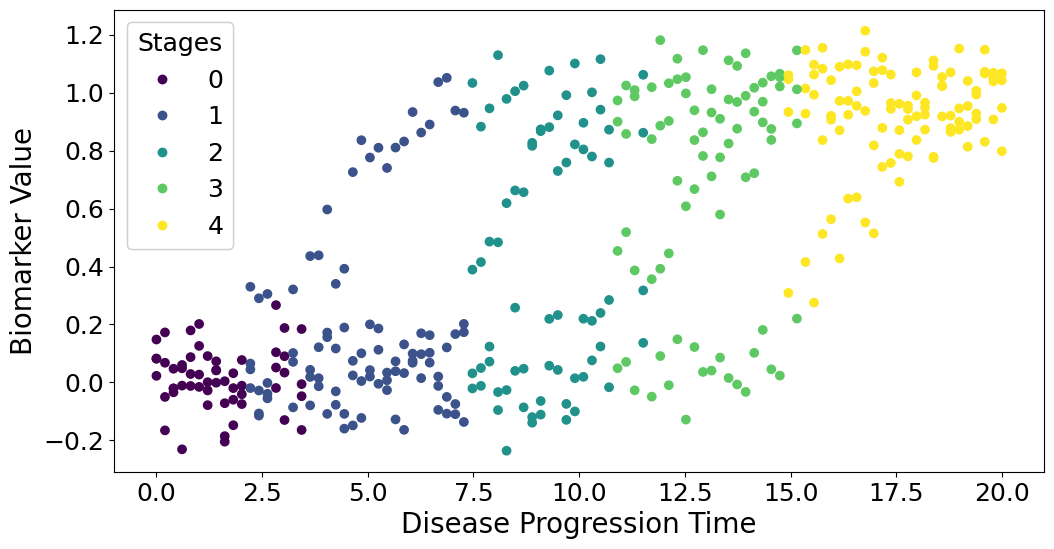

In [23]:
#* Plot the original data, coloured by stage
fig,ax = plt.subplots(figsize=(12,6))

for k in range(num_features):
    scatter = plt.scatter(disease_time,X_combined[Y_combined==1,k],c=stages_long[Y_combined==1],cmap='viridis',label='')
#ax.legend(['Stage %i' % k for k in range(num_stages)],loc='center right',bbox_to_anchor=[1.5,0.5])
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Stages")
ax.add_artist(legend1)
ax.set_xlabel("Disease Progression Time",fontsize=20) 
ax.set_ylabel("Biomarker Value",fontsize=20)



## Bonus: Cross-validation

The generalisability/robustness of a model can be quantified by **testing** the model on independent data, i.e., data not included when training the model.

Cross-validation does this by splitting the available data into train/test sets.

### k-fold cross-validation

Splitting a dataset into `k` "folds" enables the calculation of model performance statistics (e.g., mean, standard deviation) over `k` test sets, using the other `k-1` folds to train the model each time.

It is common to use `k=10`, which amounts to using 90% of your data to train and 10% to test.

This process can be repeated multiple times using different random partitions (splits) into folds.


## k-fold cross-validation
![image_kfold_cv](https://upload.wikimedia.org/wikipedia/commons/b/b5/K-fold_cross_validation_EN.svg)

By Gufosowa - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=82298768

## Using k-fold cross-validation of EBM
* In the full notebook in the repository, we will use `k=5` folds and repeat the k-fold CV process for 10 random splits.
* This fits the EBM 50 times, where four folds are used to build the EBM and one is held out for testing.
* If you have time, have a look at the cross-validation code and let us know if you have any questions.

## Thanks and good luck with the final task!